In [1]:
import sys
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

datasets = ["graph500_26"] #, "graph500_28", "graph500_30"]
RESULTS_DIR = "results"
DATASET_DIR = "datasets"

#we now need to construct a dataframe with the following columns:
#dataset, benchmark, system, preprocessing_time,exec_time

df_results = pd.DataFrame(columns=['dataset', 'benchmark', 'system', 'preprocessing_time', 'exec_time'])

In [2]:
# Configure matplotlib for high-quality rendering
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# For Jupyter notebooks with retina displays
%config InlineBackend.figure_format = 'retina'

## Data Loading and Processing

We'll create a dataframe for each system containing algorithm execution and preprocessing times.
All times will be normalized to seconds for consistent comparison.

### GAPBS

In [3]:
# Galois Data Loading
# Note: Galois uses milliseconds and has multiple runs per algorithm
# Note: BC file is empty, so we'll skip it
galois_files = {
    'BFS': 'results/galois/graph500_26_bfs_synctile_parallel_time.csv',
    'PageRank': 'results/galois/graph500_26_pagerank-pull_residual.csv',
    'CC': 'results/galois/graph500_26_connectedcomponents_labelprop.csv',
    'Triangle': 'results/galois/graph500_26_triangle_orderedCount.csv'
}

galois_data = []
for algo, filepath in galois_files.items():
    df = pd.read_csv(filepath)
    # Convert milliseconds to seconds and take mean of multiple runs
    # Galois preprocessing = conv_time (already in seconds) + mean(read_time in ms)
    preprocess_time = df['conv_time(s)'].mean() + (df['read_time(ms)'].mean() / 1000.0)
    galois_data.append({
        'algorithm': algo,
        'exec_time': df['algo_time(ms)'].mean() / 1000.0,  # Convert ms to seconds
        'preprocessing_time': preprocess_time,
        'memory_mb': df['mem_used(MB)'].mean(),
        'num_threads': df['num_threads'].iloc[0]  # Same across all runs
    })

df_galois = pd.DataFrame(galois_data)
print("Galois Results:")
print(df_galois)

Galois Results:
  algorithm  exec_time  preprocessing_time  memory_mb  num_threads
0       BFS    81.2050            473.1216    24958.0           96
1  PageRank   103.6494            473.1750    23736.0           96
2        CC    15.5780            473.1090    23736.6           96
3  Triangle    90.0534            563.0256    50355.2           96


### Galois

In [4]:
# Gemini Data Loading
# Note: Gemini doesn't have Triangle Counting
gemini_files = {
    'BFS': 'results/gemini/graph500_26_bfs.csv',
    'PageRank': 'results/gemini/graph500_26_pagerank.csv',
    'CC': 'results/gemini/graph500_26_cc.csv'
}

gemini_data = []
for algo, filepath in gemini_files.items():
    df = pd.read_csv(filepath)
    # Strip whitespace from column names
    df.columns = df.columns.str.strip()
    # Gemini preprocessing = convert_time + read_time
    preprocess_time = df['convert_time(s)'].values[0] + df['read_time(s)'].values[0]
    gemini_data.append({
        'algorithm': algo,
        'exec_time': df['algo_time(s)'].values[0],
        'preprocessing_time': preprocess_time,
        'memory_mb': df['mem(MB)'].values[0],
        'num_threads': df['num_threads'].values[0]
    })

df_gemini = pd.DataFrame(gemini_data)
print("Gemini Results:")
print(df_gemini)

Gemini Results:
  algorithm  exec_time  preprocessing_time  memory_mb  num_threads
0       BFS     0.0695             63.3966       6245          192
1  PageRank     1.0123             61.1832       7197          192
2        CC     0.3985             72.3362       6897          192


### Gemini

In [5]:
# Ligra Data Loading
# Note: Ligra CSV files have spaces after commas in column names
ligra_files = {
    'BFS': 'results/ligra/graph500_26_BFS.csv',
    'PageRank': 'results/ligra/graph500_26_PageRank.csv',
    'CC': 'results/ligra/graph500_26_Components.csv',
    'Triangle': 'results/ligra/graph500_26_Triangle.csv',
    'BC': 'results/ligra/graph500_26_BC.csv'
}

ligra_data = []
for algo, filepath in ligra_files.items():
    df = pd.read_csv(filepath)
    # Strip whitespace from column names
    df.columns = df.columns.str.strip()
    # Ligra preprocessing = convert_time + read_time
    preprocess_time = df['convert_time(s)'].values[0] + df['read_time(s)'].values[0]
    ligra_data.append({
        'algorithm': algo,
        'exec_time': df['algo_time(s)'].values[0],
        'preprocessing_time': preprocess_time,
        'memory_mb': df['memory(MB)'].values[0],
        'num_threads': np.nan  # Ligra doesn't report threads in CSV
    })

df_ligra = pd.DataFrame(ligra_data)
print("Ligra Results:")
print(df_ligra)

Ligra Results:
  algorithm  exec_time  preprocessing_time  memory_mb  num_threads
0       BFS     0.1264          508.701319      69850          NaN
1  PageRank    72.2000          508.701319      69850          NaN
2        CC     4.4160          508.701319      69850          NaN
3  Triangle   914.6000          508.701319      69850          NaN
4        BC     1.1180          508.701319      69852          NaN


### Ligra

In [6]:
# GAPBS Data Loading
gapbs_files = {
    'BFS': 'results/gapbs/graph500_26_bfs.csv',
    'PageRank': 'results/gapbs/graph500_26_pr.csv',
    'CC': 'results/gapbs/graph500_26_cc.csv',
    'Triangle': 'results/gapbs/graph500_26_tc.csv',
    'BC': 'results/gapbs/graph500_26_bc.csv'
}

gapbs_data = []
for algo, filepath in gapbs_files.items():
    df = pd.read_csv(filepath)
    # Strip whitespace from column names
    df.columns = df.columns.str.strip()
    gapbs_data.append({
        'algorithm': algo,
        'exec_time': df['algo_time(s)'].values[0],
        'preprocessing_time': df['pp_time(s)'].values[0],
        'memory_mb': df['mem_used(MB)'].values[0] if df['mem_used(MB)'].values[0] != 0 else np.nan,
        'num_threads': df['num_threads'].values[0]
    })

df_gapbs = pd.DataFrame(gapbs_data)
print("GAPBS Results:")
print(df_gapbs)

GAPBS Results:
  algorithm  exec_time  preprocessing_time  memory_mb  num_threads
0       BFS     0.0868            106.7561        NaN           96
1  PageRank     4.4342            107.2392        NaN           96
2        CC     0.1192            106.7335        NaN           96
3  Triangle    71.1752            106.9458        NaN           96
4        BC     2.3916            106.5952        NaN           96


### Flexograph

In [7]:
# Flexograph Data Loading
# Note: Flexograph uses log format with multiple runs
flexograph_file = 'results/flexograph/graph500_26_pr_adj.log'

# Parse the log file
with open(flexograph_file, 'r') as f:
    lines = f.readlines()

# Extract graph loading time and PR execution times
graph_load_time = None
pr_times = []

for line in lines:
    line = line.strip()
    if 'Graph loaded in' in line:
        # Extract time from "Graph loaded in X.XXXXs"
        match = re.search(r'Graph loaded in\s+([\d.]+)s', line)
        if match:
            graph_load_time = float(match.group(1))
    elif 'PR  completed in :' in line:
        # Extract time from "PR  completed in : XX.XXXXs"
        match = re.search(r'PR\s+completed in\s+:\s+([\d.]+)s', line)
        if match:
            pr_times.append(float(match.group(1)))

flexograph_data = []
if graph_load_time is not None and pr_times:
    flexograph_data.append({
        'algorithm': 'PageRank',
        'exec_time': np.mean(pr_times),
        'preprocessing_time': graph_load_time,
        'memory_mb': np.nan,  # Not available in log
        'num_threads': np.nan  # Not available in log
    })

df_flexograph = pd.DataFrame(flexograph_data)
print("Flexograph Results:")
print(df_flexograph)
print(f"\nNumber of PR runs: {len(pr_times)}")
print(f"PR time range: {min(pr_times):.4f}s - {max(pr_times):.4f}s")
print(f"PR time std dev: {np.std(pr_times):.4f}s")

Flexograph Results:
  algorithm  exec_time  preprocessing_time  memory_mb  num_threads
0  PageRank  32.884825              6.2389        NaN          NaN

Number of PR runs: 20
PR time range: 32.6651s - 33.3873s
PR time std dev: 0.1992s


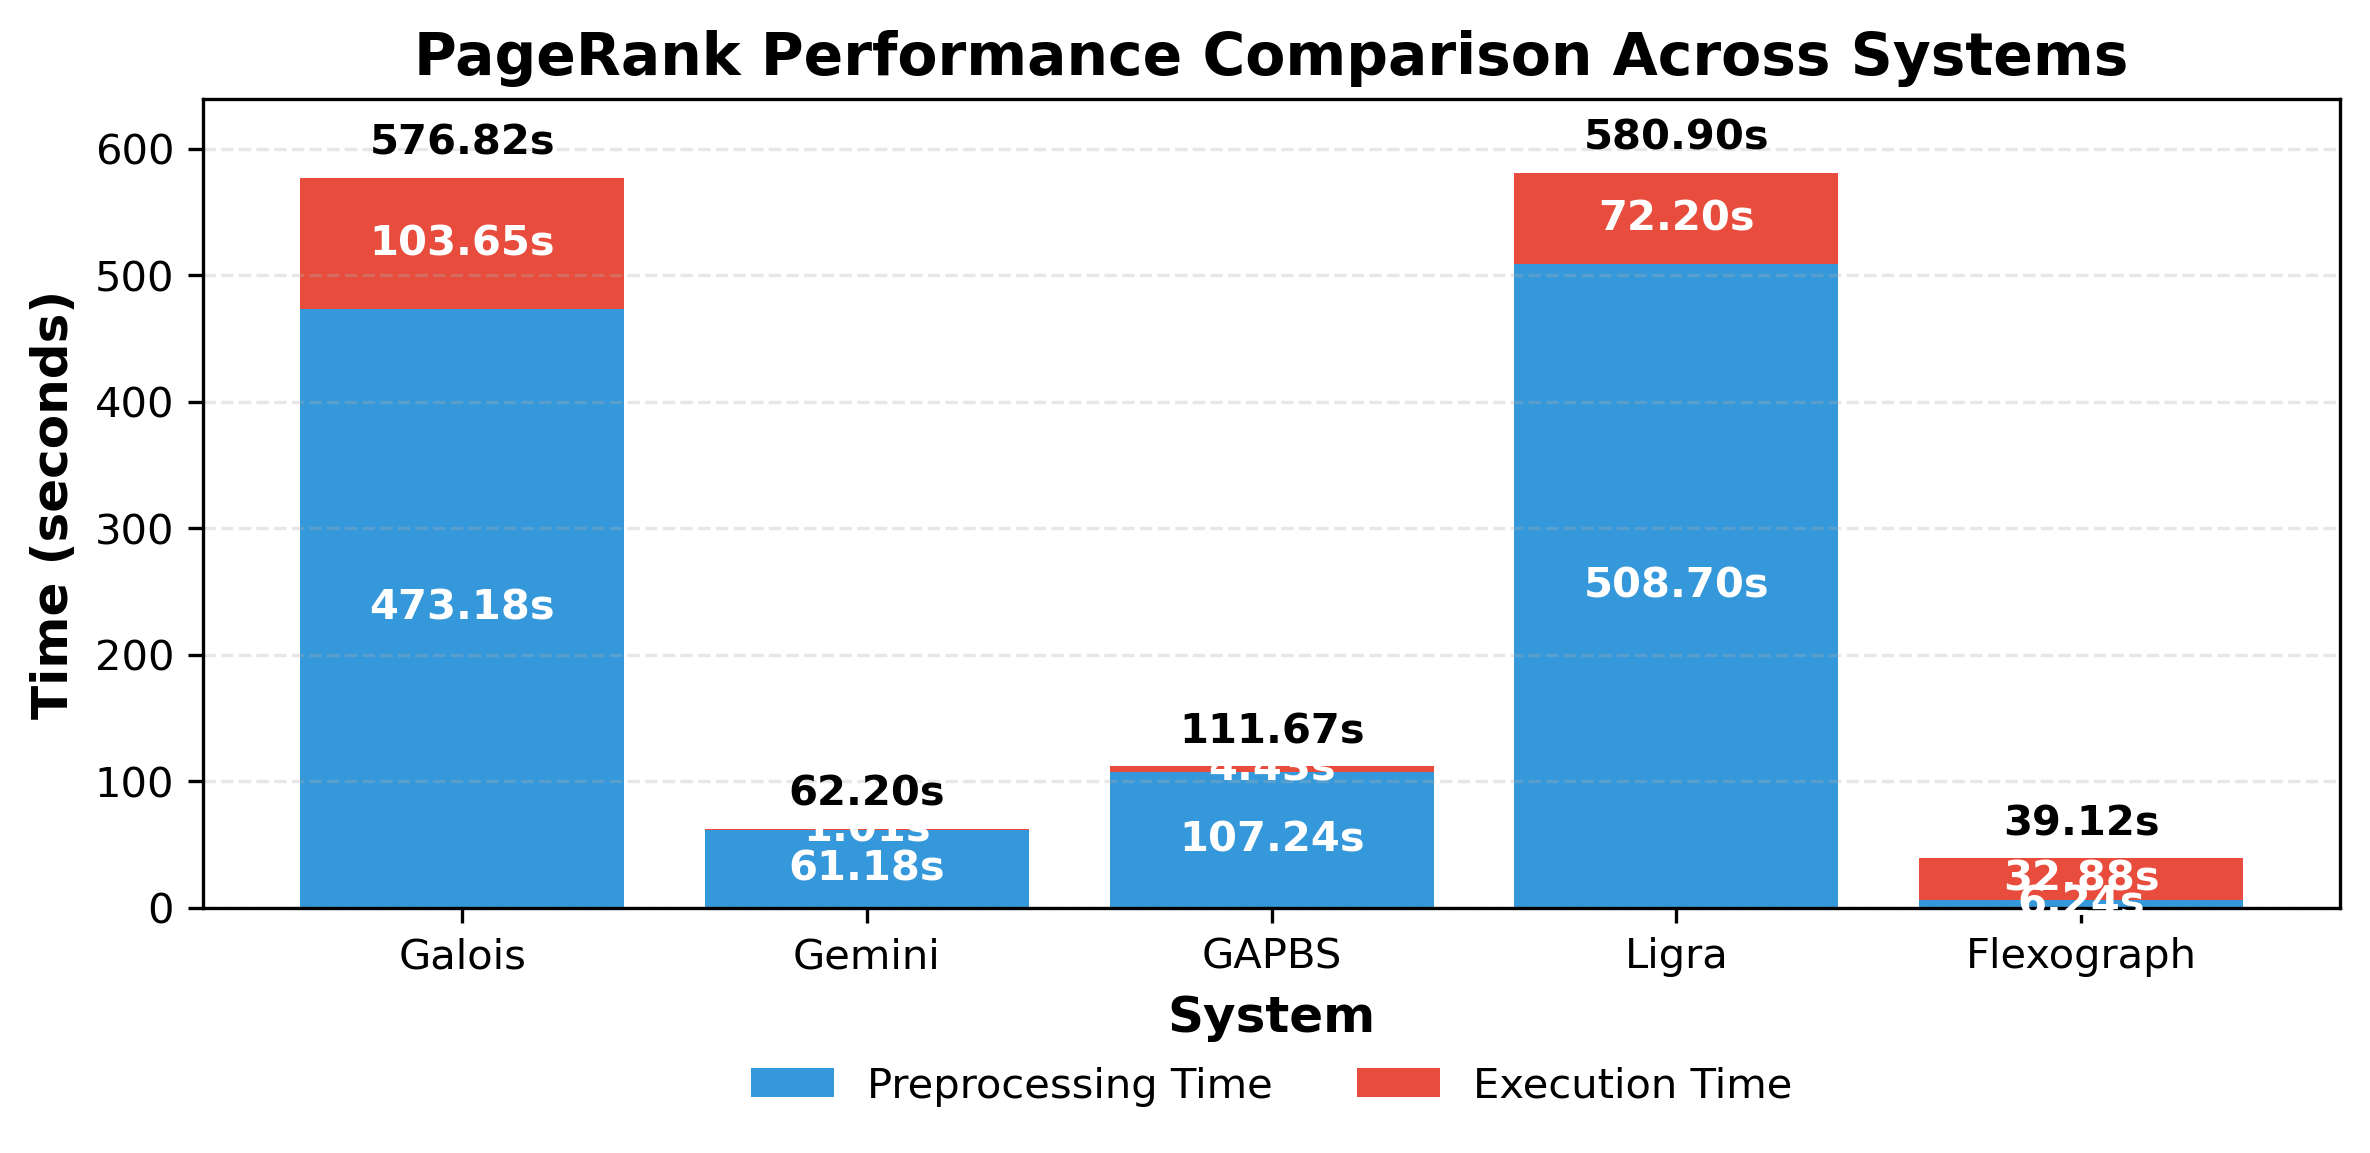


PageRank Performance Summary:
------------------------------------------------------------
Galois     | Preprocessing:   473.18s | Execution:   103.65s | Total:   576.82s
Gemini     | Preprocessing:    61.18s | Execution:     1.01s | Total:    62.20s
GAPBS      | Preprocessing:   107.24s | Execution:     4.43s | Total:   111.67s
Ligra      | Preprocessing:   508.70s | Execution:    72.20s | Total:   580.90s
Flexograph | Preprocessing:     6.24s | Execution:    32.88s | Total:    39.12s


In [8]:
# Extract PageRank data from all systems
pagerank_data = {
    'Galois': df_galois[df_galois['algorithm'] == 'PageRank'].iloc[0],
    'Gemini': df_gemini[df_gemini['algorithm'] == 'PageRank'].iloc[0],
    'GAPBS': df_gapbs[df_gapbs['algorithm'] == 'PageRank'].iloc[0],
    'Ligra': df_ligra[df_ligra['algorithm'] == 'PageRank'].iloc[0],
    'Flexograph': df_flexograph[df_flexograph['algorithm'] == 'PageRank'].iloc[0]
}

# Create dataframe for plotting
systems = list(pagerank_data.keys())
preprocessing_times = [pagerank_data[sys]['preprocessing_time'] for sys in systems]
exec_times = [pagerank_data[sys]['exec_time'] for sys in systems]

# Create stacked bar plot
fig, ax = plt.subplots(figsize=(8, 4))

# Plot bars
x_pos = np.arange(len(systems))
bars1 = ax.bar(x_pos, preprocessing_times, label='Preprocessing Time', color='#3498db')
bars2 = ax.bar(x_pos, exec_times, bottom=preprocessing_times, label='Execution Time', color='#e74c3c')

# Customize plot
ax.set_xlabel('System', fontsize=12, fontweight='bold')
ax.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('PageRank Performance Comparison Across Systems', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(systems)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Set y-axis limit to give space for labels above bars
max_total = max([preprocessing_times[i] + exec_times[i] for i in range(len(systems))])
ax.set_ylim(0, max_total * 1.1)

# Add value labels on bars
for i, (prep, exec_t) in enumerate(zip(preprocessing_times, exec_times)):
    # Preprocessing time label
    ax.text(i, prep/2, f'{prep:.2f}s', ha='center', va='center', fontweight='bold', color='white')
    # Execution time label
    ax.text(i, prep + exec_t/2, f'{exec_t:.2f}s', ha='center', va='center', fontweight='bold', color='white')
    # Total time label above bar
    ax.text(i, prep + exec_t + max_total*0.02, 
            f'{prep + exec_t:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('pagerank_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\nPageRank Performance Summary:")
print("-" * 60)
for sys in systems:
    prep = pagerank_data[sys]['preprocessing_time']
    exec_t = pagerank_data[sys]['exec_time']
    total = prep + exec_t
    print(f"{sys:10s} | Preprocessing: {prep:8.2f}s | Execution: {exec_t:8.2f}s | Total: {total:8.2f}s")

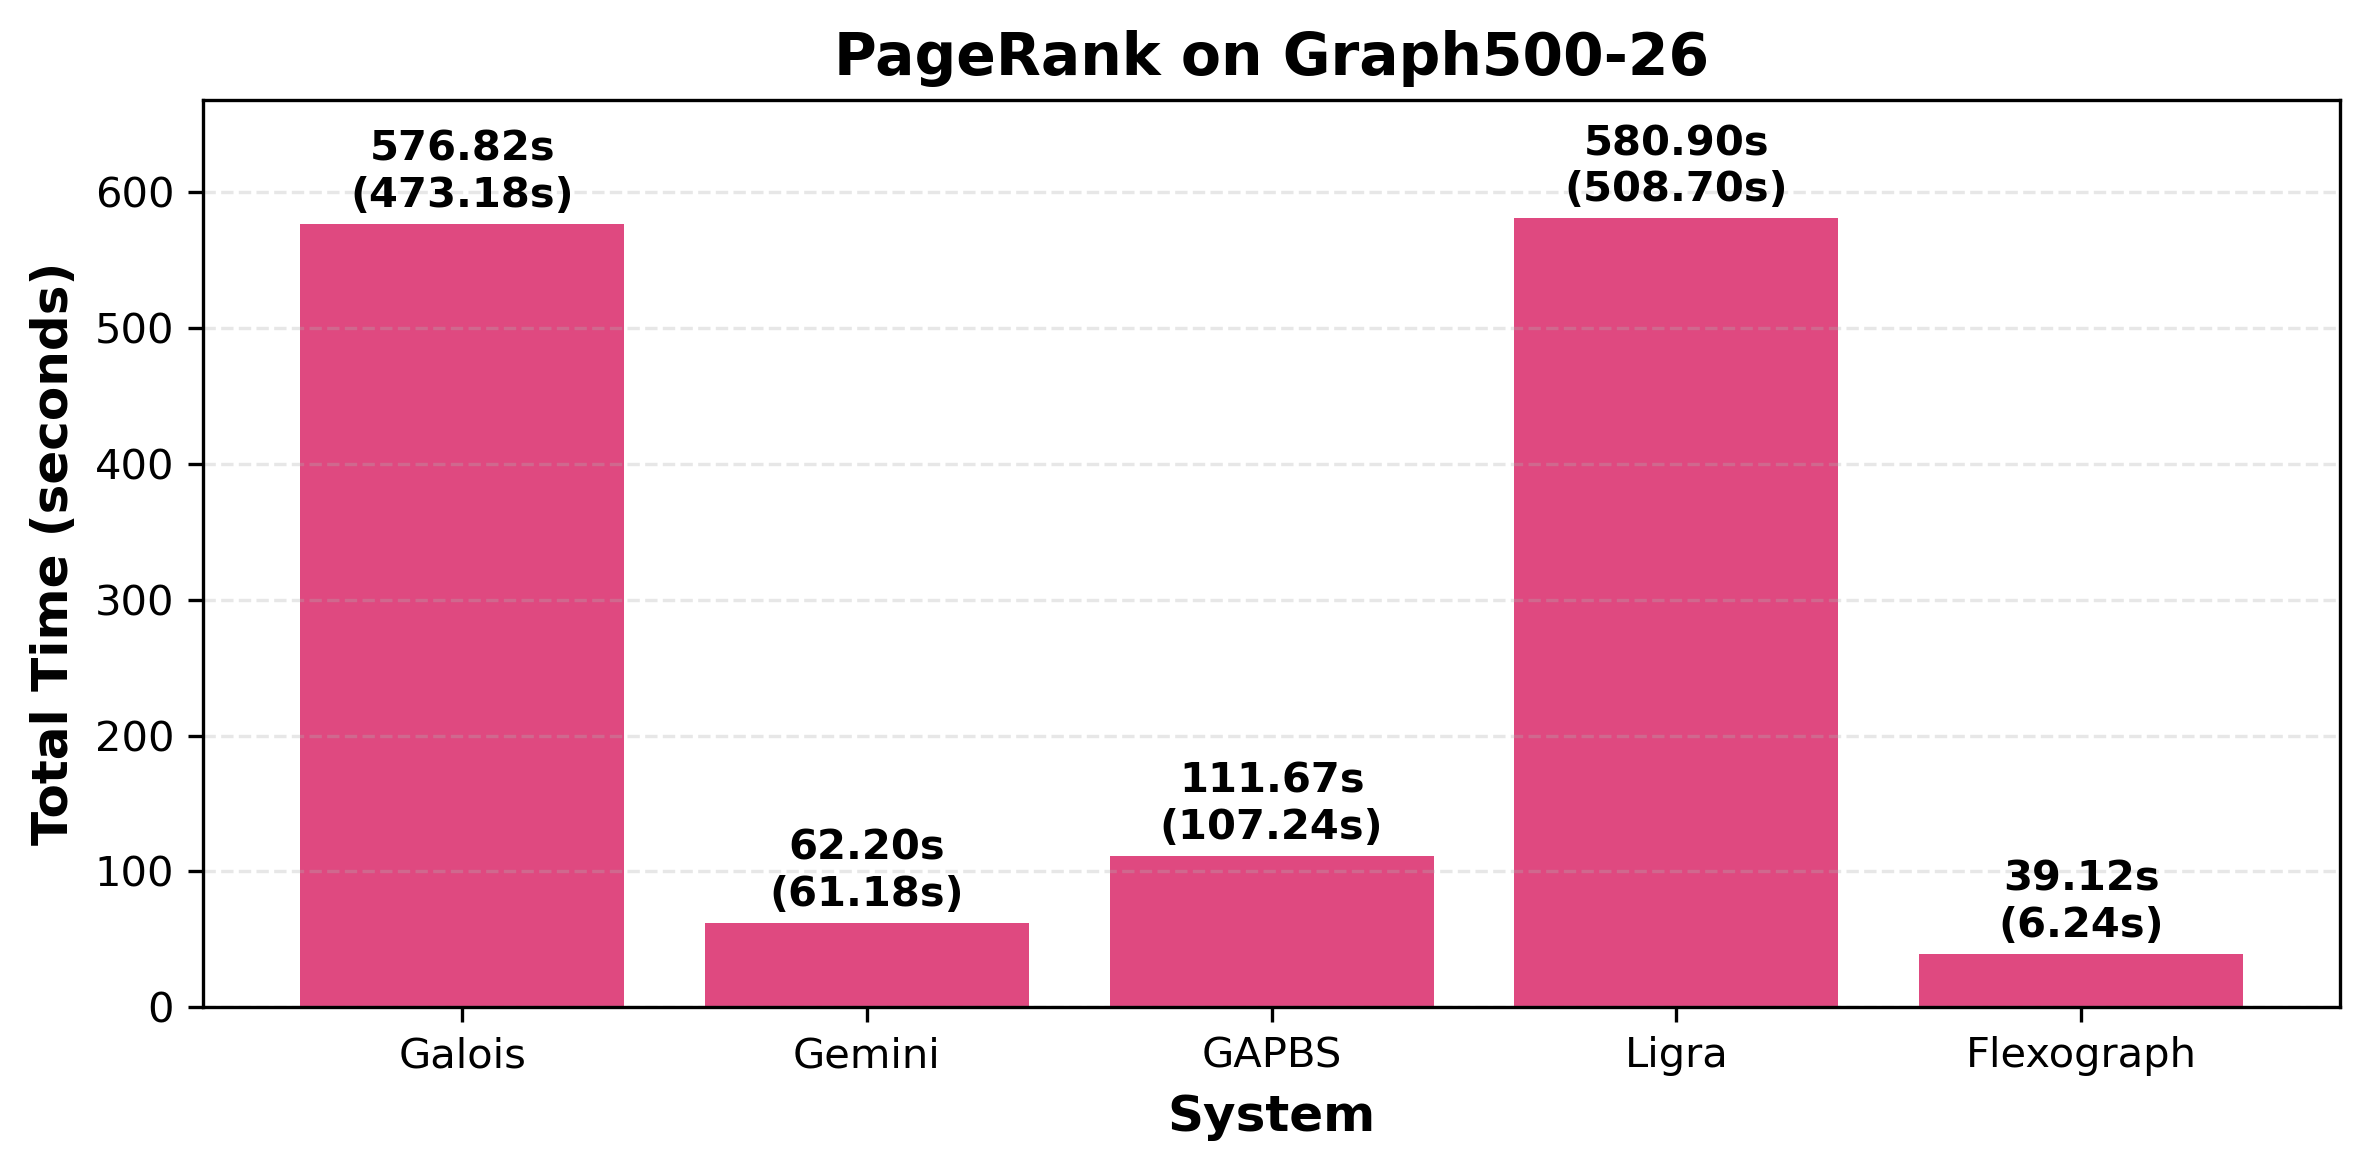

In [11]:
# Alternative visualization: Total time with preprocessing in brackets
fig, ax = plt.subplots(figsize=(8, 4))

# Calculate total times
total_times = [preprocessing_times[i] + exec_times[i] for i in range(len(systems))]

# Plot bars showing total time
x_pos = np.arange(len(systems))
bars = ax.bar(x_pos, total_times, color='#D81B60', alpha=0.8)

# Customize plot
ax.set_xlabel('System', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('PageRank on Graph500-26', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(systems)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Set y-axis limit to give space for labels above bars
max_total = max(total_times)
ax.set_ylim(0, max_total * 1.15)

# Add labels above bars: total_time\n(preprocessing_time)
for i, (prep, total) in enumerate(zip(preprocessing_times, total_times)):
    label = f'{total:.2f}s\n({prep:.2f}s)'
    ax.text(i, total + max_total*0.01, label, ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('pagerank_graph500_26.pdf', dpi=1500, bbox_inches='tight')
plt.show()